In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [84]:
train_start_date = '2021-01-01'
train_end_date = '2023-12-31'
predict_start_date = '2024-01-01'
predict_end_date = '2024-12-31'

btc = yf.download('BTC-USD', start=train_start_date, end=predict_end_date)
print(btc.head())

[*********************100%***********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-01-01  28994.009766  29600.626953  28803.585938  29374.152344   
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   

               Adj Close       Volume  
Date                                   
2021-01-01  29374.152344  40730301359  
2021-01-02  32127.267578  67865420765  
2021-01-03  32782.023438  78665235202  
2021-01-04  31971.914062  81163475344  
2021-01-05  33992.429688  67547324782  


In [85]:
# Wyodrębnij dane do treningu i testowania na podstawie dat
date = pd.to_datetime(predict_start_date)
new_date = date - pd.Timedelta(days=100)
train_data = btc.loc[train_start_date:train_end_date]['Close'].values.reshape(-1, 1)
test_data = btc.loc[new_date.strftime('%Y-%m-%d'):predict_end_date]['Close'].values.reshape(-1, 1)
print(len(train_data), len(test_data))

print(btc.loc[predict_start_date:predict_end_date])

1095 385
                    Open          High           Low         Close  \
Date                                                                 
2024-01-01  42280.234375  44175.437500  42214.976562  44167.332031   
2024-01-02  44187.140625  45899.707031  44176.949219  44957.968750   
2024-01-03  44961.601562  45503.242188  40813.535156  42848.175781   
2024-01-04  42855.816406  44770.023438  42675.175781  44179.921875   
2024-01-05  44192.980469  44353.285156  42784.718750  44162.691406   
...                  ...           ...           ...           ...   
2024-10-07  62819.109375  64443.707031  62152.550781  62236.660156   
2024-10-08  62221.644531  63174.304688  61843.562500  62131.968750   
2024-10-09  62131.726562  62508.835938  60314.613281  60582.101562   
2024-10-10  60581.929688  61236.722656  58895.207031  60274.500000   
2024-10-12  62512.046875  62867.019531  62487.484375  62696.750000   

               Adj Close       Volume  
Date                                   


In [86]:
# 3. Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
print(type(scaler))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)
print(len(train_data_scaled), len(test_data_scaled))

<class 'sklearn.preprocessing._data.MinMaxScaler'>
1095 385


In [87]:
# 4. Podział danych na zestawy treningowe i testowe
# train_size = int(len(btc_close_scaled) * 0.8)  # 80% danych do treningu
# train_data, test_data = btc_close_scaled[0:train_size], btc_close_scaled[train_size:len(btc_close_scaled)]
# print(train_size)
# print(len(btc_close_scaled))


In [88]:
# 5. Przygotowanie danych do LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [89]:
time_step = 100
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)


In [90]:
# 6. Konwersja danych do formatu akceptowanego przez LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(len(X_train), len(X_test))

994 284


In [91]:
# 7. Tworzenie modelu LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.summary()

C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Trenowanie modelu
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0412 - val_loss: 0.0051
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2

In [93]:
# 9. Predykcja na danych testowych
predictions = model.predict(X_test)
print(predictions[:10])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
[[0.5068984 ]
 [0.5404878 ]
 [0.5586287 ]
 [0.5238363 ]
 [0.54269344]
 [0.542999  ]
 [0.5405647 ]
 [0.5393271 ]
 [0.59288865]
 [0.58279914]]


In [94]:
# 10. Odwrotna transformacja dla porównania z rzeczywistymi danymi
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print(y_test[:10])

[[44167.33203125]
 [44957.96875   ]
 [42848.17578125]
 [44179.921875  ]
 [44162.69140625]
 [43989.1953125 ]
 [43943.09765625]
 [46970.50390625]
 [46139.73046875]
 [46627.77734375]]


In [95]:
print(len(predictions))
print(len(X_test))

284
284


284
285


ConversionError: Failed to convert value(s) to axis units: '2024-01-01'

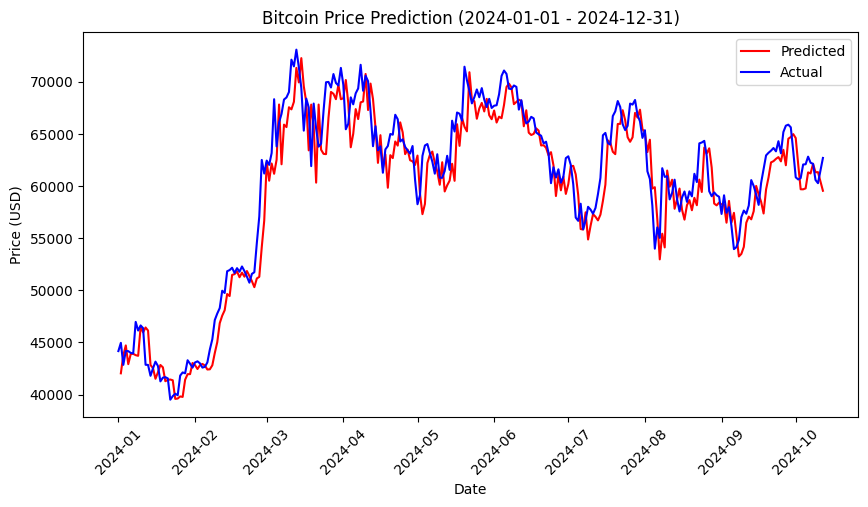

In [96]:
# Wizualizacja prognozy i rzeczywistych danych dla roku 2023
plt.figure(figsize=(10, 5))

# Daty testowe (dla prognoz)
test_dates = btc.loc[new_date.strftime('%Y-%m-%d'):predict_end_date].index[time_step + 1:len(predictions) + time_step + 1]
print(len(test_dates))
# Wykres przewidywań
plt.plot(test_dates, predictions, label='Predicted', color='red')

# Wyświetlanie rzeczywistych cen dla tego okresu
actual_prices = btc['Close'].loc[predict_start_date:predict_end_date]
actual_dates = actual_prices.index
print(len(actual_dates))
plt.plot(actual_dates, actual_prices, label='Actual', color='blue')

plt.title(f'Bitcoin Price Prediction ({predict_start_date} - {predict_end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.xlim([predict_start_date, predict_end_date])  # Ustawiamy zakres osi X
plt.show()

print(predictions)
